This notebook performs a thorough EDA of the dataset, as well as engineers features, and performs additional QA on these modifications.

We:
- Standardize columns

- Search for duplicates and other flaws
- Understand and QA (pre and post-modifications) the distributions of our spans across subcorpora
- Understand and QA (pre and post-modifications) the quartiles of the continous outcome variable 'complexity', the counts across datasets and subsets, the counts of subcorpora, the quantity of more complex vs. less complex spans—coming to the conclusion that we have a rigorously balanced and consistent dataset
- Eliminate contractions across the data, creating 2 versions of the original X variable, per single and multi set (4 total)
- Create two binarized outcome variables (derived from the continous 'complexity' outcome variable), such that we split on the median of the single set's train set and apply it to the validation and test set, and repeat the procedure for the multi set's train set. Then, in order to test for excessive neutrality (given that the continuous label was derived from a 5-increment likert scale, which itself was derived from an average of continuous annotator ratings), we split on the 75th percentile and trained models on that in order to rule out intrinsic issues with the dataset. The resulting datset balances can be seen in the binomial distribution plots in this notebook. Thus, we create 2 versions of the original Y variable, per single and multi set (4 total), excluding the original continous variable from consideration for training.
- Enrich and augment the dataset with features derived from SpaCy, creating 4 new purely derived features per set (8 total). We then systematically leverage the derived features to generate 7 new versions of our X variable per dataset (14 total)—such that 3 features per set (6 total) contain concatenations of engineered features and our expanded raw X variable, 3 features per set (6 total) interleave each token of both the SpaCy features and the original X variable, and 1 feature per set was generated concatenating the raw X variable with a SpaCy-derived complexity score (2 total)—thus injecting an alternative continous value into the input sequence.

At each step, modifications were tested for quality control, and later used systematically in training experiments.


In [ ]:
#@title Install Packages

In [ ]:
!pip install -q transformers
!pip install -q torchinfo
!pip install -q datasets
!pip install -q evaluate
!pip install -q nltk
!pip install -q contractions

In [ ]:
!sudo apt-get update
! sudo apt-get install tree

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
#@title Imports
import nltk
from nltk.tokenize import RegexpTokenizer

import evaluate
import transformers

import contractions

from torchinfo import summary
from datasets import load_dataset

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

import spacy

In [ ]:
# @title Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir_root = '/content/drive/MyDrive/266-final/'
# dir_data = '/content/drive/MyDrive/266-final/data/'
# dir_data = '/content/drive/MyDrive/266-final/data/se21-t1-comp-lex-master/'
dir_data = '/content/drive/MyDrive/266-final/data/266-comp-lex-master'
dir_models = '/content/drive/MyDrive/266-final/models/'
dir_results = '/content/drive/MyDrive/266-final/results/'

In [ ]:
!tree /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/
├── fe-test-labels
│   ├── test_multi_df.csv
│   └── test_single_df.csv
├── fe-train
│   ├── train_multi_df.csv
│   └── train_single_df.csv
├── fe-trial-val
│   ├── trial_val_multi_df.csv
│   └── trial_val_single_df.csv
├── test-labels
│   ├── lcp_multi_test.tsv
│   └── lcp_single_test.tsv
├── train
│   ├── lcp_multi_train.tsv
│   └── lcp_single_train.tsv
└── trial
    ├── lcp_multi_trial.tsv
    └── lcp_single_trial.tsv

6 directories, 12 files


In [ ]:
!ls -R /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/:
fe-test-labels	fe-train  fe-trial-val	test-labels  train  trial

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels:
test_multi_df.csv  test_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train:
train_multi_df.csv  train_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val:
trial_val_multi_df.csv	trial_val_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/test-labels:
lcp_multi_test.tsv  lcp_single_test.tsv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/train:
lcp_multi_train.tsv  lcp_single_train.tsv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/trial:
lcp_multi_trial.tsv  lcp_single_trial.tsv


In [ ]:
#@title Import Data

In [ ]:
# Load train data into train_*_df
train_single_df = pd.read_csv(
    os.path.join(dir_data, "train", "lcp_single_train.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)
train_multi_df = pd.read_csv(
    os.path.join(dir_data, "train", "lcp_multi_train.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)

# Load trial data into trial_val_*_df
trial_val_single_df = pd.read_csv(
    os.path.join(dir_data, "trial", "lcp_single_trial.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)
trial_val_multi_df = pd.read_csv(
    os.path.join(dir_data, "trial", "lcp_multi_trial.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)

# Load test data (with labels) into test_*_df
test_single_df = pd.read_csv(
    os.path.join(dir_data, "test-labels", "lcp_single_test.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)
test_multi_df = pd.read_csv(
    os.path.join(dir_data, "test-labels", "lcp_multi_test.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)

print("Data successfully loaded into train, trial-val, and test variables")

Data successfully loaded into train, trial-val, and test variables


In [ ]:
#@title EDA

In [ ]:
def print_dataframe_summary(df_name, df):
    # Print section header
    print(f"========== {df_name} ==========")

    # Shape and Columns
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}\n")

    # Data Types
    print("Data Types:")
    print(df.dtypes)
    print()

    # Missing Values
    print("Missing Values (by column):")
    print(df.isna().sum())
    print()

    # 'complexity' column stats
    desc = df['complexity'].describe()  # count, mean, std, min, 25%, 50%, 75%, max
    print("'complexity' Column Stats (incl. quartiles and median):")
    print(desc)

    # Calculate frequency counts for each quartile range
    q1 = desc['25%']
    q2 = desc['50%']  # This is the median
    q3 = desc['75%']
    q_max = desc['max']

    # Note: We'll define the ranges as:
    #   <= Q1
    #   > Q1 and <= Q2
    #   > Q2 and <= Q3
    #   > Q3

    freq_q1 = np.sum(df['complexity'] <= q1)
    freq_q2 = np.sum((df['complexity'] > q1) & (df['complexity'] <= q2))
    freq_q3 = np.sum((df['complexity'] > q2) & (df['complexity'] <= q3))
    freq_q4 = np.sum(df['complexity'] > q3)

    print()
    print("Quartile Frequency Counts (tab-separated next to each quartile):")
    print(f"25%: {q1}\tCount (<= Q1): {freq_q1}")
    print(f"50% (Median): {q2}\tCount (Q1 < x <= Q2): {freq_q2}")
    print(f"75%: {q3}\tCount (Q2 < x <= Q3): {freq_q3}")
    print(f"100% (Max): {q_max}\tCount (Q3 < x <= Max): {freq_q4}")

    print("======================================\n")

# Now we call this for each of our dataframes
print_dataframe_summary("train_single_df", train_single_df)
print_dataframe_summary("train_multi_df", train_multi_df)
print_dataframe_summary("trial_val_single_df", trial_val_single_df)
print_dataframe_summary("trial_val_multi_df", trial_val_multi_df)
print_dataframe_summary("test_single_df", test_single_df)
print_dataframe_summary("test_multi_df", test_multi_df)


========== train_single_df ==========
Shape: (7662, 5)
Columns: ['id', 'corpus', 'sentence', 'token', 'complexity']

Data Types:
id             object
corpus         object
sentence       object
token          object
complexity    float64
dtype: object

Missing Values (by column):
id            0
corpus        0
sentence      0
token         7
complexity    0
dtype: int64

'complexity' Column Stats (incl. quartiles and median):
count    7662.000000
mean        0.302288
std         0.132977
min         0.000000
25%         0.211538
50%         0.279412
75%         0.375000
max         0.861111
Name: complexity, dtype: float64

Quartile Frequency Counts (tab-separated next to each quartile):
25%: 0.2115384615384615	Count (<= Q1): 1928
50% (Median): 0.2794117647058823	Count (Q1 < x <= Q2): 1937
75%: 0.375	Count (Q2 < x <= Q3): 1984
100% (Max): 0.8611111111111112	Count (Q3 < x <= Max): 1813

========== train_multi_df ==========
Shape: (1517, 5)
Columns: ['id', 'corpus', 'sentence', 'token'

In [ ]:
print(train_single_df.head())

                               id corpus                                           sentence     token  complexity
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible  Behold, there came up out of the river seven c...     river    0.000000
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C  bible  I am a fellow bondservant with you and with yo...  brothers    0.000000
2  3S1WOPCJFGTJU2SGNAN2Y213N6WJE3  bible  The man, the lord of the land, said to us, 'By...  brothers    0.050000
3  3BFNCI9LYKQN09BHXHH9CLSX5KP738  bible  Shimei had sixteen sons and six daughters; but...  brothers    0.150000
4  3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2  bible               "He has put my brothers far from me.  brothers    0.263889


In [ ]:
print(train_multi_df.head())

                               id corpus                                           sentence            token  complexity
0  3S37Y8CWI80N8KVM53U4E6JKCDC4WE  bible  but the seventh day is a Sabbath to Yahweh you...      seventh day    0.027778
1  3WGCNLZJKF877FYC1Q6COKNWTDWD11  bible  But let each man test his own work, and then h...         own work    0.050000
2  3UOMW19E6D6WQ5TH2HDD74IVKTP5CB  bible  To him who by understanding made the heavens; ...  loving kindness    0.050000
3  36JW4WBR06KF9AXMUL4N476OMF8FHD  bible  Remember to me, my God, this also, and spare m...  loving kindness    0.050000
4  3HRWUH63QU2FH9Q8R7MRNFC7JX2N5A  bible  Because your loving kindness is better than li...  loving kindness    0.075000


In [ ]:
#@title Data Engineering

In [ ]:
# Assuming you have already loaded the DataFrames:
# train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df

def print_distinct_values(df, column_name):
    """Prints the distinct values of a specified column in a DataFrame."""
    distinct_values = df[column_name].unique()
    print(f"Distinct values in '{column_name}' column:")
    for value in distinct_values:
        print(value)
    print("-" * 30)  # Separator

# Print distinct values for each DataFrame
print_distinct_values(train_single_df, "corpus")
print_distinct_values(train_multi_df, "corpus")
print_distinct_values(trial_val_single_df, "subcorpus")
print_distinct_values(trial_val_multi_df, "subcorpus")
print_distinct_values(test_single_df, "corpus")
print_distinct_values(test_multi_df, "corpus")

Distinct values in 'corpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'corpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'subcorpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'subcorpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'corpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'corpus' column:
bible
biomed
europarl
------------------------------


## standardize column headers: convert trial_val header from 'subcorpus' to 'corpus'

In [ ]:
# Rename the 'subcorpus' column to 'corpus'
trial_val_single_df = trial_val_single_df.rename(columns={'subcorpus': 'corpus'})
trial_val_multi_df = trial_val_multi_df.rename(columns={'subcorpus': 'corpus'})

# Verify the change (optional)
print(trial_val_single_df.columns)
print(trial_val_multi_df.columns)

Index(['id', 'corpus', 'sentence', 'token', 'complexity'], dtype='object')
Index(['id', 'corpus', 'sentence', 'token', 'complexity'], dtype='object')


In [ ]:
dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]

# Get the headers (column names) of the first DataFrame as a reference
reference_headers = list(dataframes[0].columns)

# Loop through the remaining DataFrames and compare headers
all_headers_match = True
for df in dataframes[1:]:
    if list(df.columns) != reference_headers:
        all_headers_match = False
        print(f"Headers do not match for DataFrame: {df.head(0)}")  # Print which DataFrame has different headers
        break  # Exit the loop if a mismatch is found

# Print the result
if all_headers_match:
    print("All DataFrames have matching headers.")
else:
    print("Headers do not match for all DataFrames.")

All DataFrames have matching headers.


## Interrogate Span Length by Corpus Value by Data Split

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile(dfs_dict):
    """
    Analyze sentence spans (length metrics) grouped by corpus and complexity quartile
    for multiple dataframes.
    """
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name}...")

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df = df.copy()
        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(word) for word in words]) if word_count > 0 else 0
            return pd.Series({'word_count': word_count, 'char_count': char_count, 'avg_word_len': avg_word_len})

        span_metrics = df['sentence'].apply(compute_span_metrics)
        df = pd.concat([df, span_metrics], axis=1)

        corpus_col = 'corpus' if 'corpus' in df.columns else 'subcorpus'

        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])

    return results_df

dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis = analyze_sentence_spans_by_corpus_and_quartile(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
display(span_analysis)

results_path = os.path.join(dir_results, 'sentence_span_analysis.csv')
span_analysis.to_csv(results_path, index=False)
print(f"Analysis saved to: {results_path}")

Processing train_single_df...
Processing train_multi_df...
Processing trial_val_single_df...
Processing trial_val_multi_df...
Processing test_single_df...
Processing test_multi_df...


,Dataframe,Corpus,Quartile,Complexity Range,Count,Avg Words,Median Words,Min Words,Max Words,Std Words,Avg Chars,Avg Word Len
60,test_multi_df,bible,Q1,0.025-0.317,26,23.076923,22.0,4.0,48.0,11.831900,118.653846,4.128898
61,test_multi_df,bible,Q2,0.325-0.417,11,20.545455,17.0,7.0,47.0,12.917923,109.545455,4.209752
62,test_multi_df,bible,Q3,0.432-0.528,18,21.111111,21.5,4.0,43.0,10.889222,112.777778,4.474206
63,test_multi_df,bible,Q4,0.542-0.694,11,22.363636,20.0,7.0,51.0,11.935432,126.181818,4.605062
64,test_multi_df,biomed,Q1,0.000-0.312,11,29.818182,29.0,17.0,47.0,8.388304,195.727273,5.491145
65,test_multi_df,biomed,Q2,0.324-0.417,11,27.090909,24.0,9.0,47.0,11.449494,171.818182,5.436237
66,test_multi_df,biomed,Q3,0.456-0.528,10,26.900000,26.5,10.0,49.0,10.712921,177.500000,5.497409
67,test_multi_df,biomed,Q4,0.562-0.800,21,32.285714,34.0,14.0,56.0,13.598319,209.285714,5.460101
68,test_multi_df,europarl,Q1,0.214-0.303,10,24.700000,24.5,7.0,56.0,14.189589,146.900000,5.049688
69,test_multi_df,europarl,Q2,0.321-0.429,24,27.833333,27.0,9.0,73.0,15.352855,172.291667,5.269610


Analysis saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis.csv


<ipython-input-56-00a8ad5642c1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(span_analysis, x='Avg Words', y='Dataframe', inner='stick', palette='Dark2')


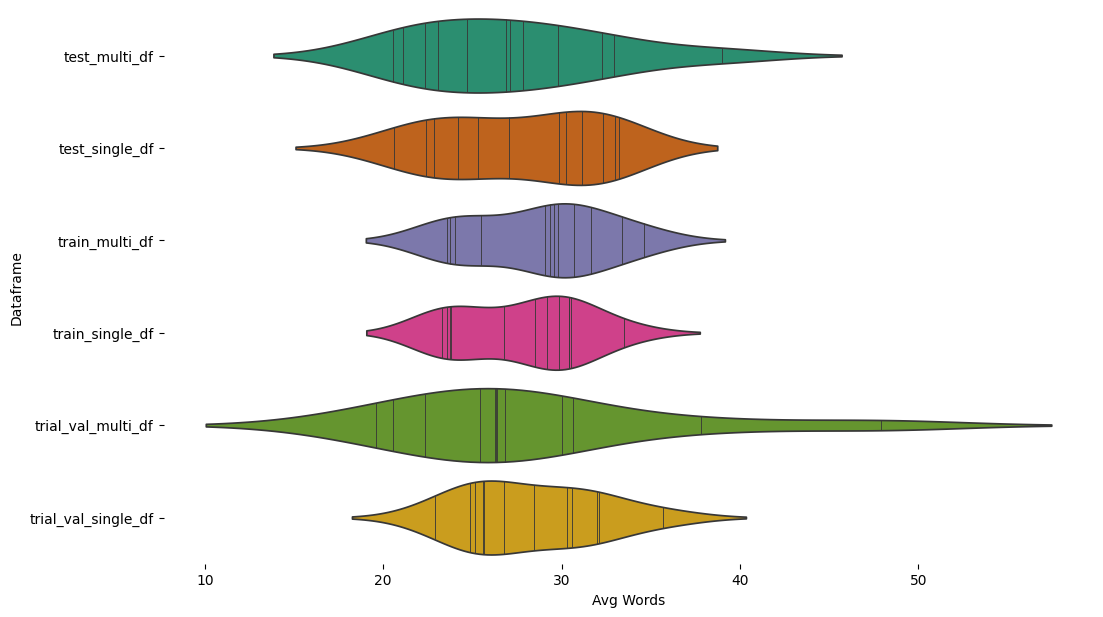

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(span_analysis['Dataframe'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(span_analysis, x='Avg Words', y='Dataframe', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

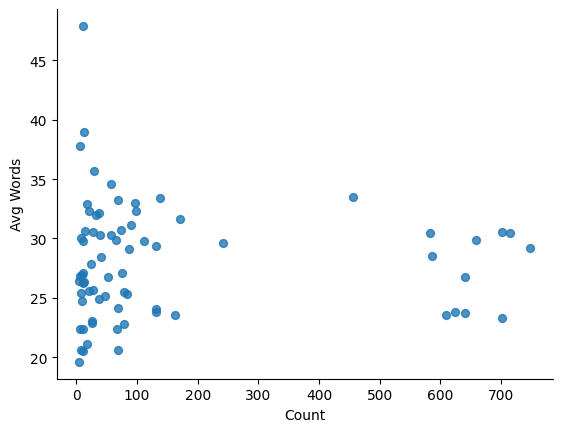

In [ ]:
from matplotlib import pyplot as plt
span_analysis.plot(kind='scatter', x='Count', y='Avg Words', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-58-01bf0c89d620>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(span_analysis, x='Max Words', y='Dataframe', inner='stick', palette='Dark2')


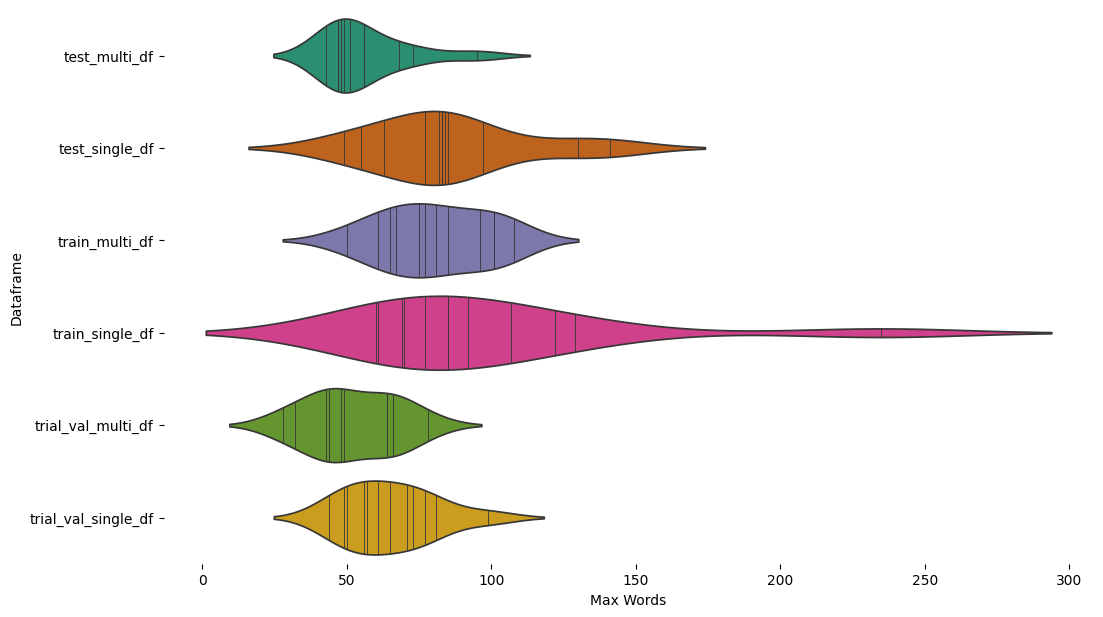

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(span_analysis['Dataframe'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(span_analysis, x='Max Words', y='Dataframe', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

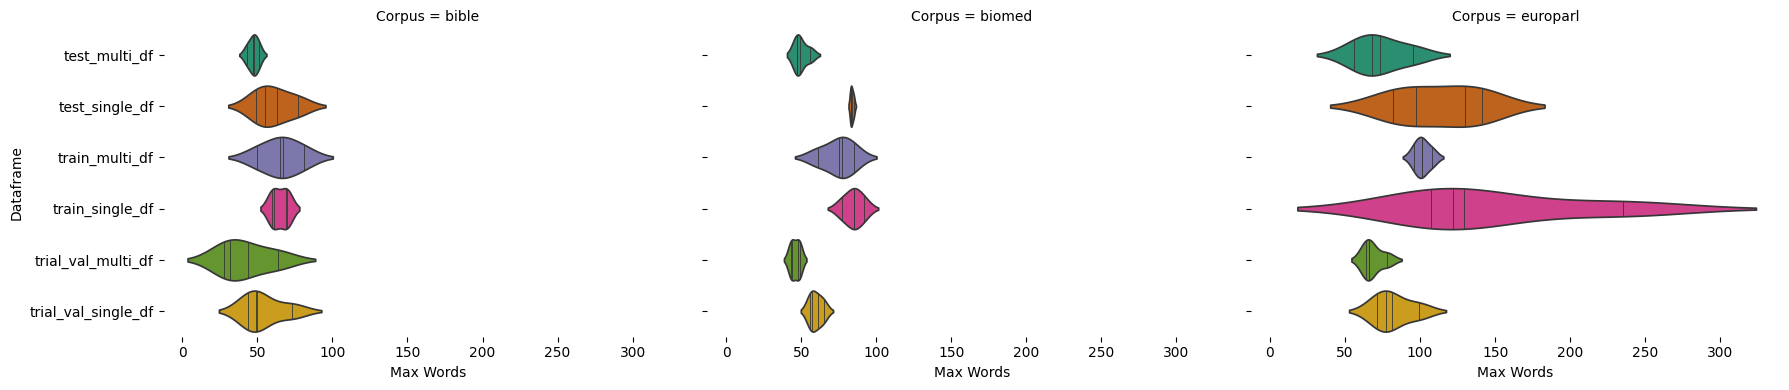

In [ ]:
g = sns.FacetGrid(span_analysis, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()

- decision: no modifications to sentence spans will be applied, except for Contraction standardization

## Normalize / Eliminate Contractions

In [ ]:
def expand_contractions_in_df(df):
    """
    1) Creates a new column 'sentence_no_contractions' by expanding any contractions.
    2) Identifies rows where a contraction was actually expanded (the text changed).
    3) Returns the updated DataFrame and a grouped subset of rows for printing examples.
    """
    df = df.copy()
    df['sentence_no_contractions'] = df['sentence'].apply(
        lambda s: contractions.fix(s) if pd.notna(s) else s
    )

    df['contraction_expanded'] = df.apply(
        lambda row: row['sentence'] != row['sentence_no_contractions'], axis=1
    )

    results_by_corpus = {}
    for corpus_val, group in df.groupby('corpus'):
        changed_rows = group[group['contraction_expanded']]
        first_three = changed_rows.head(3)
        results_by_corpus[corpus_val] = first_three
    return df, results_by_corpus


dataframes_info = [
    ("train_single_df", train_single_df),
    ("train_multi_df", train_multi_df),
    ("trial_val_single_df", trial_val_single_df),
    ("trial_val_multi_df", trial_val_multi_df),
    ("test_single_df", test_single_df),
    ("test_multi_df", test_multi_df),
]

for df_name, df in dataframes_info:
    updated_df, corpus_examples = expand_contractions_in_df(df)
    globals()[df_name] = updated_df

    print(f"\n{'='*60}")
    print(f"DataFrame: {df_name}")
    print(f"{'='*60}")

    for corpus_val in sorted(corpus_examples.keys()):
        subset = corpus_examples[corpus_val]
        if len(subset) == 0:
            continue
        print(f"\n  Corpus: {corpus_val}")
        print("    -- BEFORE --")
        for _, row in subset.iterrows():
            print(f"       {row['sentence']}")
        print("    -- AFTER  --")
        for _, row in subset.iterrows():
            print(f"       {row['sentence_no_contractions']}")


DataFrame: train_single_df

  Corpus: bible
    -- BEFORE --
       Shimei had sixteen sons and six daughters; but his brothers didn't have many children, neither did all their family multiply like the children of Judah.
       When his speech is charming, don't believe him; for there are seven abominations in his heart.
       Jesus said, "Father, forgive them, for they don't know what they are doing."
    -- AFTER  --
       Shimei had sixteen sons and six daughters; but his brothers did not have many children, neither did all their family multiply like the children of Judah.
       When his speech is charming, do not believe him; for there are seven abominations in his heart.
       Jesus said, "Father, forgive them, for they do not know what they are doing."

  Corpus: biomed
    -- BEFORE --
       Although missense mutation of ITPR1 had previously been ruled out [2] and the mode of inheritance was inconsistent with that seen in the Itpr1Δ18 and Itpr1opt mice, the phenotypic pres

In [ ]:
# check for null values

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df['sentence_no_contractions'].isnull().values.any())

False
False
False
False
False
False


In [ ]:
dataframes = {
    "train_single_df": train_single_df,
    "train_multi_df": train_multi_df,
    "trial_val_single_df": trial_val_single_df,
    "trial_val_multi_df": trial_val_multi_df,
    "test_single_df": test_single_df,
    "test_multi_df": test_multi_df
}

total_true_counts = 0
for df_name, df in dataframes.items():
    true_count = df['contraction_expanded'].sum()
    print(f"{df_name}: {true_count} True values in 'contraction_expanded'")
    total_true_counts += true_count

print(f"\nTotal True values across all dataframes: {total_true_counts}")

train_single_df: 254 True values in 'contraction_expanded'
train_multi_df: 54 True values in 'contraction_expanded'
trial_val_single_df: 16 True values in 'contraction_expanded'
trial_val_multi_df: 0 True values in 'contraction_expanded'
test_single_df: 31 True values in 'contraction_expanded'
test_multi_df: 7 True values in 'contraction_expanded'

Total True values across all dataframes: 362


In [ ]:
# verify column headers

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        7662 non-null   object 
 1   corpus                    7662 non-null   object 
 2   sentence                  7662 non-null   object 
 3   token                     7655 non-null   object 
 4   complexity                7662 non-null   float64
 5   sentence_no_contractions  7662 non-null   object 
 6   contraction_expanded      7662 non-null   bool   
dtypes: bool(1), float64(1), object(5)
memory usage: 366.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1517 entries, 0 to 1516
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1517 non-null   object 
 1   corpus                    1517 non-null   object 
 2   

In [ ]:
# inspect each df

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.head())

                               id corpus                                           sentence     token  complexity                           sentence_no_contractions  contraction_expanded
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible  Behold, there came up out of the river seven c...     river    0.000000  Behold, there came up out of the river seven c...                 False
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C  bible  I am a fellow bondservant with you and with yo...  brothers    0.000000  I am a fellow bondservant with you and with yo...                 False
2  3S1WOPCJFGTJU2SGNAN2Y213N6WJE3  bible  The man, the lord of the land, said to us, 'By...  brothers    0.050000  The man, the lord of the land, said to us, 'By...                 False
3  3BFNCI9LYKQN09BHXHH9CLSX5KP738  bible  Shimei had sixteen sons and six daughters; but...  brothers    0.150000  Shimei had sixteen sons and six daughters; but...                  True
4  3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2  bible               "He has pu

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    """
    Analyze sentence spans (length metrics) grouped by corpus and complexity quartile
    for multiple dataframes, but this time using the 'sentence_no_contractions' column
    instead of the original 'sentence'.
    """
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'sentence_no_contractions'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['sentence_no_contractions'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
display(span_analysis_nc)


Processing train_single_df on 'sentence_no_contractions'...
Processing train_multi_df on 'sentence_no_contractions'...
Processing trial_val_single_df on 'sentence_no_contractions'...
Processing trial_val_multi_df on 'sentence_no_contractions'...
Processing test_single_df on 'sentence_no_contractions'...
Processing test_multi_df on 'sentence_no_contractions'...


,Dataframe,Corpus,Quartile,Complexity Range,Count,Avg Words,Median Words,Min Words,Max Words,Std Words,Avg Chars,Avg Word Len
60,test_multi_df,bible,Q1,0.025-0.317,26,23.076923,22.0,4.0,48.0,11.831900,118.730769,4.131249
61,test_multi_df,bible,Q2,0.325-0.417,11,20.545455,17.0,7.0,47.0,12.917923,109.636364,4.213539
62,test_multi_df,bible,Q3,0.432-0.528,18,21.055556,21.5,4.0,43.0,10.843660,113.166667,4.498610
63,test_multi_df,bible,Q4,0.542-0.694,11,22.363636,20.0,7.0,51.0,11.935432,126.181818,4.605062
64,test_multi_df,biomed,Q1,0.000-0.312,11,29.818182,29.0,17.0,47.0,8.388304,195.727273,5.491145
65,test_multi_df,biomed,Q2,0.324-0.417,11,27.090909,24.0,9.0,47.0,11.449494,171.818182,5.436237
66,test_multi_df,biomed,Q3,0.456-0.528,10,26.900000,26.5,10.0,49.0,10.712921,177.500000,5.497409
67,test_multi_df,biomed,Q4,0.562-0.800,21,32.285714,34.0,14.0,56.0,13.598319,209.285714,5.460101
68,test_multi_df,europarl,Q1,0.214-0.303,10,24.700000,24.5,7.0,56.0,14.189589,146.900000,5.049688
69,test_multi_df,europarl,Q2,0.321-0.429,24,27.833333,27.0,9.0,73.0,15.352855,172.291667,5.269610


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

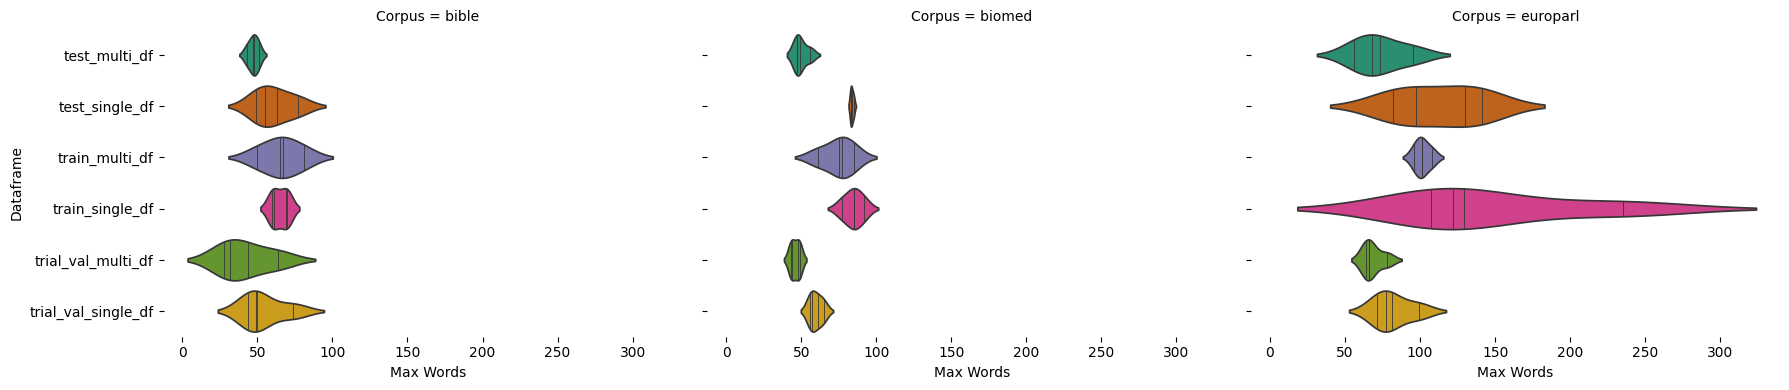

In [ ]:
g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()

- contraction processing successfuly, confirmed with Avg Word deltas between 'sentence' and 'sentence_no_contractions'

## Enrich Datset with PoS Tags, Dependency Parsing, and Morphological Complexity

In [ ]:
# !pip install -q spacy
# !python -m spacy download en_core_web_trf
!python -m spacy download en_core_web_lg

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.8.0/en_core_web_lg-3.8.0-py3-none-any.whl (400.7 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load("en_core_web_lg")


In [ ]:
text = "This is a sample sentence for testing spaCy."

doc = nlp(text)

for token in doc:
    print(f"Token: {token.text}, POS: {token.pos_}, Dependency: {token.dep_}")


Token: This, POS: PRON, Dependency: nsubj
Token: is, POS: AUX, Dependency: ROOT
Token: a, POS: DET, Dependency: det
Token: sample, POS: NOUN, Dependency: compound
Token: sentence, POS: NOUN, Dependency: attr
Token: for, POS: ADP, Dependency: prep
Token: testing, POS: VERB, Dependency: pcomp
Token: spaCy, POS: PROPN, Dependency: dobj
Token: ., POS: PUNCT, Dependency: punct


In [ ]:
def enrich_with_spacy(df, text_col='sentence_no_contractions'):
    """
    Processes the 'text_col' with spaCy and appends:
      pos_sequence, dep_sequence, morph_sequence,
      and morph_complexity (float) per row.
    """
    df = df.copy()

    pos_tags = []
    dep_tags = []
    morph_tags = []
    morph_complexities = []

    for text in df[text_col]:
        if pd.isna(text) or not text.strip():
            pos_tags.append([])
            dep_tags.append([])
            morph_tags.append([])
            morph_complexities.append(0.0)
            continue

        doc = nlp(text)

        pos_seq = [token.pos_ for token in doc]
        dep_seq = [token.dep_ for token in doc]
        morph_seq = [token.morph for token in doc]

        total_features = 0
        for token in doc:
            features_dict = token.morph.to_dict()
            total_features += len(features_dict)

        avg_morph = total_features / len(doc)

        pos_tags.append(pos_seq)
        dep_tags.append(dep_seq)
        morph_tags.append(morph_seq)
        morph_complexities.append(avg_morph)

    df['pos_sequence'] = pos_tags
    df['dep_sequence'] = dep_tags
    df['morph_sequence'] = morph_tags
    df['morph_complexity'] = morph_complexities

    return df


In [ ]:
dataframes_info = [
    ("train_single_df", train_single_df),
    ("train_multi_df", train_multi_df),
    ("trial_val_single_df", trial_val_single_df),
    ("trial_val_multi_df", trial_val_multi_df),
    ("test_single_df", test_single_df),
    ("test_multi_df", test_multi_df),
]

for df_name, df in dataframes_info:
    print(f"Enriching {df_name} with spaCy features...")
    enriched_df = enrich_with_spacy(df, text_col='sentence_no_contractions')
    globals()[df_name] = enriched_df
    print(f"Done! Now '{df_name}' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.\n")


Enriching train_single_df with spaCy features...
Done! Now 'train_single_df' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.

Enriching train_multi_df with spaCy features...
Done! Now 'train_multi_df' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.

Enriching trial_val_single_df with spaCy features...
Done! Now 'trial_val_single_df' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.

Enriching trial_val_multi_df with spaCy features...
Done! Now 'trial_val_multi_df' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.

Enriching test_single_df with spaCy features...
Done! Now 'test_single_df' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.

Enriching test_multi_df with spaCy features...
Done! Now 'test_multi_df' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.



In [ ]:
for df_name, df in dataframes_info:
    print(f"\n{'='*50}")
    print(f"DataFrame: {df_name}")
    print(f"{'='*50}\n")
    sample_df = globals()[df_name].sample(3, random_state=42)
    display(sample_df[['sentence_no_contractions', 'pos_sequence', 'dep_sequence', 'morph_sequence', 'morph_complexity']])



DataFrame: train_single_df



,sentence_no_contractions,pos_sequence,dep_sequence,morph_sequence,morph_complexity
5061,The transgenic approach that was used to creat...,"[DET, ADJ, NOUN, PRON, AUX, VERB, PART, VERB, ...","[det, amod, nsubjpass, nsubjpass, auxpass, rel...","[(Definite=Def, PronType=Art), (Degree=Pos), (...",1.500000
2471,"When the report comes to Egypt, they will be i...","[SCONJ, DET, NOUN, VERB, ADP, PROPN, PUNCT, PR...","[advmod, det, nsubj, advcl, prep, pobj, punct,...","[(), (Definite=Def, PronType=Art), (Number=Sin...",1.166667
800,"Saul asked counsel of God, ""Shall I go down af...","[PROPN, VERB, NOUN, ADP, PROPN, PUNCT, PUNCT, ...","[nsubj, ROOT, dobj, prep, pobj, punct, punct, ...","[(Number=Sing), (Tense=Past, VerbForm=Fin), (N...",1.200000



DataFrame: train_multi_df



,sentence_no_contractions,pos_sequence,dep_sequence,morph_sequence,morph_complexity
724,BRCA2 may thus promote RAD51 assembly into rec...,"[PROPN, AUX, ADV, VERB, PROPN, NOUN, ADP, ADJ,...","[nsubj, aux, advmod, ROOT, compound, dobj, pre...","[(Number=Sing), (VerbForm=Fin), (), (VerbForm=...",1.222222
812,"Therefore, BMPR1A appears to maintain articula...","[ADV, PUNCT, PROPN, VERB, PART, VERB, ADJ, NOU...","[advmod, punct, nsubj, ROOT, aux, xcomp, amod,...","[(), (PunctType=Comm), (Number=Sing), (Number=...",1.000000
1466,Continued support for the renewal and modernis...,"[VERB, NOUN, ADP, DET, NOUN, CCONJ, NOUN, ADP,...","[amod, nsubj, prep, det, pobj, cc, conj, prep,...","[(Aspect=Perf, Tense=Past, VerbForm=Part), (Nu...",1.205882



DataFrame: trial_val_single_df



,sentence_no_contractions,pos_sequence,dep_sequence,morph_sequence,morph_complexity
145,"However, this reduction in bone resorption occ...","[ADV, PUNCT, DET, NOUN, ADP, NOUN, NOUN, VERB,...","[advmod, punct, det, nsubj, prep, compound, po...","[(), (PunctType=Comm), (Number=Sing, PronType=...",1.0000
335,A word of thanks is also due to many non-gover...,"[DET, NOUN, ADP, NOUN, AUX, ADV, ADJ, ADP, ADJ...","[det, nsubj, prep, pobj, ROOT, advmod, prep, p...","[(Definite=Ind, PronType=Art), (Number=Sing), ...",1.0625
175,To test the hypothesis that a temporal delay i...,"[PART, VERB, DET, NOUN, SCONJ, DET, ADJ, NOUN,...","[aux, advcl, det, dobj, mark, det, amod, nsubj...","[(), (VerbForm=Inf), (Definite=Def, PronType=A...",1.2000



DataFrame: trial_val_multi_df



,sentence_no_contractions,pos_sequence,dep_sequence,morph_sequence,morph_complexity
62,"by Mr Virrankoski, on behalf of the Committee ...","[ADP, PROPN, PROPN, PUNCT, ADP, NOUN, ADP, DET...","[prep, compound, pobj, punct, prep, pobj, prep...","[(), (Number=Sing), (Number=Sing), (PunctType=...",0.892857
40,"Indeed, we recently showed that neural crest c...","[ADV, PUNCT, PRON, ADV, VERB, SCONJ, ADJ, PROP...","[advmod, punct, nsubj, advmod, ROOT, mark, com...","[(), (PunctType=Comm), (Case=Nom, Number=Plur,...",1.108696
95,"It is not an easy task, particularly for the c...","[PRON, AUX, PART, DET, ADJ, NOUN, PUNCT, ADV, ...","[nsubj, ROOT, neg, det, amod, attr, punct, adv...","[(Case=Nom, Gender=Neut, Number=Sing, Person=3...",1.180328



DataFrame: test_single_df



,sentence_no_contractions,pos_sequence,dep_sequence,morph_sequence,morph_complexity
668,It is therefore not a matter of indifference h...,"[PRON, AUX, ADV, PART, DET, NOUN, ADP, NOUN, S...","[nsubj, ROOT, advmod, neg, det, attr, prep, po...","[(Case=Nom, Gender=Neut, Number=Sing, Person=3...",1.200000
30,then shall he offer with the bull a meal offer...,"[ADV, AUX, PRON, VERB, ADP, DET, NOUN, DET, NO...","[advmod, aux, nsubj, ROOT, prep, det, pobj, de...","[(PronType=Dem), (VerbType=Mod), (Case=Nom, Ge...",1.071429
377,While they do have their limitations (e.g. dev...,"[SCONJ, PRON, AUX, VERB, PRON, NOUN, PUNCT, AD...","[mark, nsubj, aux, advcl, poss, dobj, punct, a...","[(), (Case=Nom, Number=Plur, Person=3, PronTyp...",1.157895



DataFrame: test_multi_df



,sentence_no_contractions,pos_sequence,dep_sequence,morph_sequence,morph_complexity
19,"God said, ""Let the earth yield grass, herbs yi...","[PROPN, VERB, PUNCT, PUNCT, VERB, DET, NOUN, V...","[nsubj, ROOT, punct, punct, xcomp, det, nsubj,...","[(Number=Sing), (Tense=Past, VerbForm=Fin), (P...",1.564103
42,Moreover I will make a covenant of peace with ...,"[ADV, PRON, AUX, VERB, DET, NOUN, ADP, NOUN, A...","[advmod, nsubj, aux, ccomp, det, dobj, prep, p...","[(), (Case=Nom, Number=Sing, Person=1, PronTyp...",1.550000
156,Developing innovation policy is crucial to EU ...,"[VERB, NOUN, NOUN, AUX, ADJ, ADP, PROPN, NOUN,...","[csubj, compound, dobj, ROOT, acomp, prep, com...","[(Aspect=Prog, Tense=Pres, VerbForm=Part), (Nu...",1.333333


In [ ]:
# verify column headers

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        7662 non-null   object 
 1   corpus                    7662 non-null   object 
 2   sentence                  7662 non-null   object 
 3   token                     7655 non-null   object 
 4   complexity                7662 non-null   float64
 5   sentence_no_contractions  7662 non-null   object 
 6   contraction_expanded      7662 non-null   bool   
 7   pos_sequence              7662 non-null   object 
 8   dep_sequence              7662 non-null   object 
 9   morph_sequence            7662 non-null   object 
 10  morph_complexity          7662 non-null   float64
dtypes: bool(1), float64(2), object(8)
memory usage: 606.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1517 entries, 0 to 1516
Data columns (total 11 columns):
 # 

## Create Binarized Outcome Variable, based on train_single_df median and train_multi_df median, applied to trial-val and test

In [ ]:
train_single_median = train_single_df['complexity'].median()

def binarize_complexity(value, threshold):
    """
    If value <= threshold, return 0, else return 1.
    """
    if value <= threshold:
        return 0
    else:
        return 1

train_single_df['binary_complexity'] = train_single_df['complexity'].apply(
    lambda x: binarize_complexity(x, train_single_median)
)
trial_val_single_df['binary_complexity'] = trial_val_single_df['complexity'].apply(
    lambda x: binarize_complexity(x, train_single_median)
)
test_single_df['binary_complexity'] = test_single_df['complexity'].apply(
    lambda x: binarize_complexity(x, train_single_median)
)

train_multi_median = train_multi_df['complexity'].median()

train_multi_df['binary_complexity'] = train_multi_df['complexity'].apply(
    lambda x: binarize_complexity(x, train_multi_median)
)
trial_val_multi_df['binary_complexity'] = trial_val_multi_df['complexity'].apply(
    lambda x: binarize_complexity(x, train_multi_median)
)
test_multi_df['binary_complexity'] = test_multi_df['complexity'].apply(
    lambda x: binarize_complexity(x, train_multi_median)
)

print(f"Median complexity (single): {train_single_median}")
print(f"Median complexity (multi): {train_multi_median}")

print("\nSample rows from train_single_df:")
print(train_single_df[['id', 'complexity', 'binary_complexity']].head())

print("\nSample rows from train_multi_df:")
print(train_multi_df[['id', 'complexity', 'binary_complexity']].head())


Median complexity (single): 0.2794117647058823
Median complexity (multi): 0.409090909090909

Sample rows from train_single_df:
                               id  complexity  binary_complexity
0  3ZLW647WALVGE8EBR50EGUBPU4P32A    0.000000                  0
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C    0.000000                  0
2  3S1WOPCJFGTJU2SGNAN2Y213N6WJE3    0.050000                  0
3  3BFNCI9LYKQN09BHXHH9CLSX5KP738    0.150000                  0
4  3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2    0.263889                  0

Sample rows from train_multi_df:
                               id  complexity  binary_complexity
0  3S37Y8CWI80N8KVM53U4E6JKCDC4WE    0.027778                  0
1  3WGCNLZJKF877FYC1Q6COKNWTDWD11    0.050000                  0
2  3UOMW19E6D6WQ5TH2HDD74IVKTP5CB    0.050000                  0
3  36JW4WBR06KF9AXMUL4N476OMF8FHD    0.050000                  0
4  3HRWUH63QU2FH9Q8R7MRNFC7JX2N5A    0.075000                  0


In [ ]:
# verify column headers

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        7662 non-null   object 
 1   corpus                    7662 non-null   object 
 2   sentence                  7662 non-null   object 
 3   token                     7655 non-null   object 
 4   complexity                7662 non-null   float64
 5   sentence_no_contractions  7662 non-null   object 
 6   contraction_expanded      7662 non-null   bool   
 7   pos_sequence              7662 non-null   object 
 8   dep_sequence              7662 non-null   object 
 9   morph_sequence            7662 non-null   object 
 10  morph_complexity          7662 non-null   float64
 11  binary_complexity         7662 non-null   int64  
dtypes: bool(1), float64(2), int64(1), object(8)
memory usage: 666.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIn

In [ ]:
# inspect each df

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.head())

                               id corpus                                           sentence     token  complexity                           sentence_no_contractions  contraction_expanded                                       pos_sequence                                       dep_sequence                                     morph_sequence  morph_complexity  binary_complexity
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible  Behold, there came up out of the river seven c...     river    0.000000  Behold, there came up out of the river seven c...                 False  [ADV, PUNCT, PRON, VERB, ADP, ADP, ADP, DET, N...  [advmod, punct, expl, ROOT, prt, prep, prep, d...  [(), (PunctType=Comm), (), (Tense=Past, VerbFo...          1.041667                  0
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C  bible  I am a fellow bondservant with you and with yo...  brothers    0.000000  I am a fellow bondservant with you and with yo...                 False  [PRON, AUX, DET, ADJ, NOUN, ADP, PRON, CCONJ, ...  [nsubj,

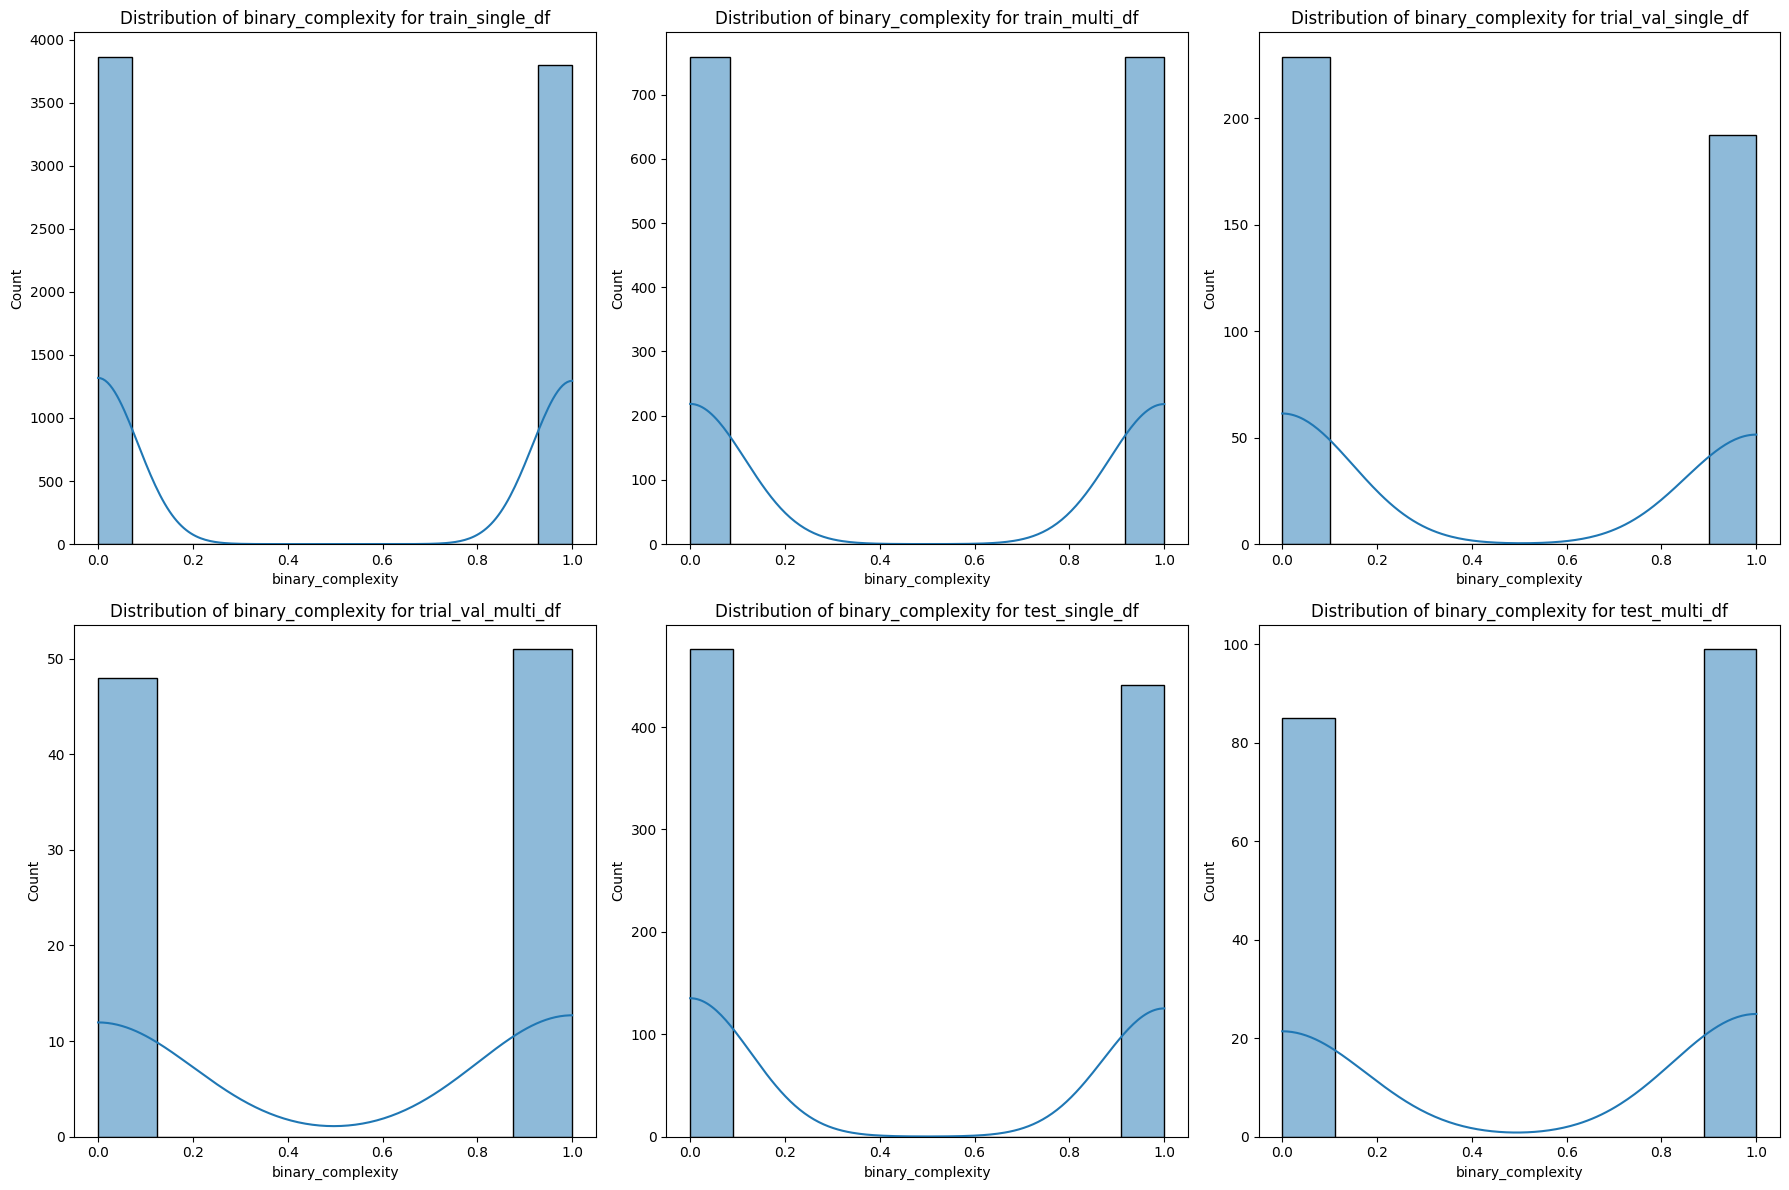

In [ ]:
dataframes = {
    "train_single_df": train_single_df,
    "train_multi_df": train_multi_df,
    "trial_val_single_df": trial_val_single_df,
    "trial_val_multi_df": trial_val_multi_df,
    "test_single_df": test_single_df,
    "test_multi_df": test_multi_df
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (df_name, df) in enumerate(dataframes.items()):
  row = i // 3
  col = i % 3
  ax = axes[row, col]
  sns.histplot(df['binary_complexity'], kde=True, ax=ax)
  ax.set_title(f'Distribution of binary_complexity for {df_name}')
  ax.set_xlabel('binary_complexity')

plt.tight_layout()
plt.show()


In [ ]:
train_single_75th = train_single_df['complexity'].quantile(0.75)
train_multi_75th = train_multi_df['complexity'].quantile(0.75)

print("75th percentile (single-track):", train_single_75th)
print("75th percentile (multi-track):", train_multi_75th)

def binarize_complexity_75th(value, threshold):
    """
    Returns 0 if 'value' <= threshold, else 1.
    """
    if value <= threshold:
        return 0
    else:
        return 1

train_single_df['binary_complexity_75th_split'] = train_single_df['complexity'].apply(
    lambda x: binarize_complexity_75th(x, train_single_75th)
)
trial_val_single_df['binary_complexity_75th_split'] = trial_val_single_df['complexity'].apply(
    lambda x: binarize_complexity_75th(x, train_single_75th)
)
test_single_df['binary_complexity_75th_split'] = test_single_df['complexity'].apply(
    lambda x: binarize_complexity_75th(x, train_single_75th)
)

train_multi_df['binary_complexity_75th_split'] = train_multi_df['complexity'].apply(
    lambda x: binarize_complexity_75th(x, train_multi_75th)
)
trial_val_multi_df['binary_complexity_75th_split'] = trial_val_multi_df['complexity'].apply(
    lambda x: binarize_complexity_75th(x, train_multi_75th)
)
test_multi_df['binary_complexity_75th_split'] = test_multi_df['complexity'].apply(
    lambda x: binarize_complexity_75th(x, train_multi_75th)
)

print("\nDistribution of 'binary_complexity_75th_split' in train_single_df:")
print(train_single_df['binary_complexity_75th_split'].value_counts())

print("\nDistribution of 'binary_complexity_75th_split' in train_multi_df:")
print(train_multi_df['binary_complexity_75th_split'].value_counts())


75th percentile (single-track): 0.375
75th percentile (multi-track): 0.5294117647058824

Distribution of 'binary_complexity_75th_split' in train_single_df:
binary_complexity_75th_split
0    5849
1    1813
Name: count, dtype: int64

Distribution of 'binary_complexity_75th_split' in train_multi_df:
binary_complexity_75th_split
0    1139
1     378
Name: count, dtype: int64


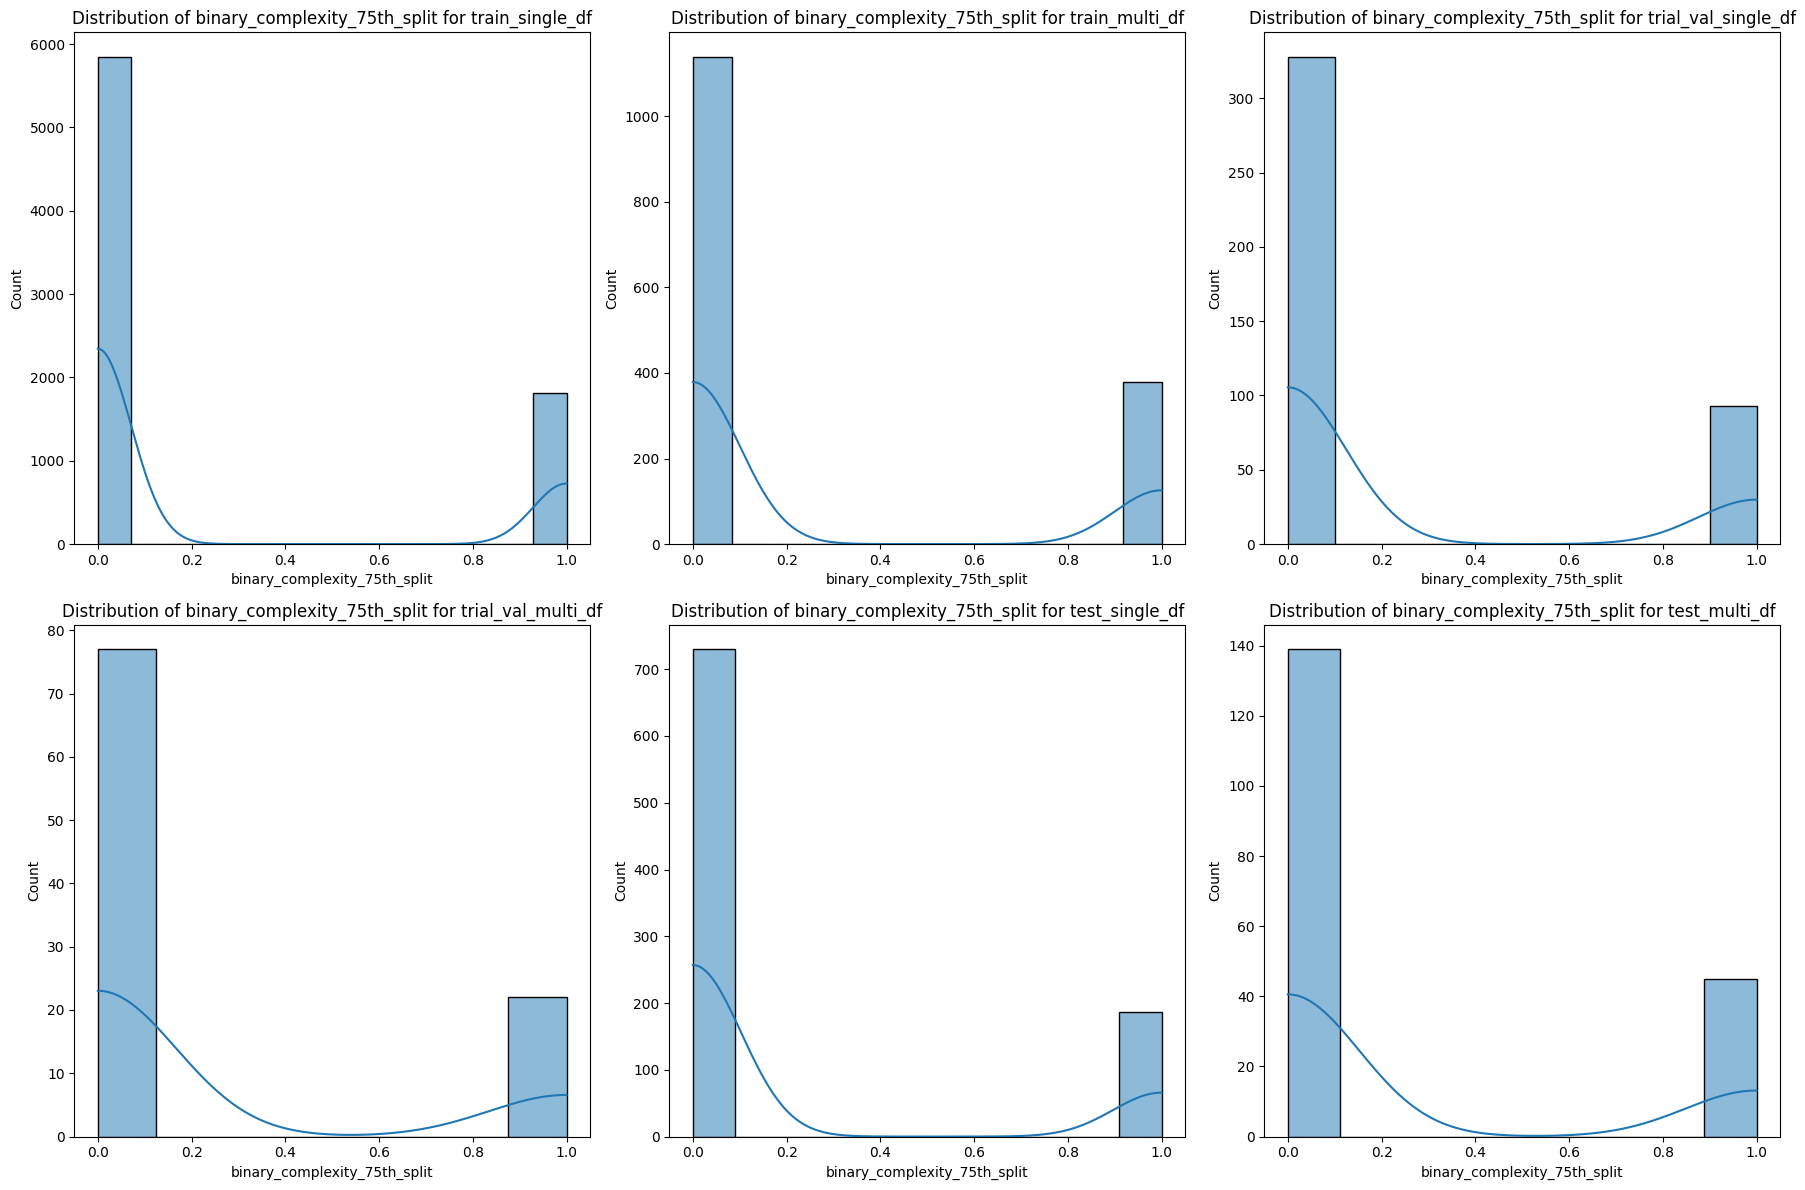

In [ ]:
dataframes = {
    "train_single_df": train_single_df,
    "train_multi_df": train_multi_df,
    "trial_val_single_df": trial_val_single_df,
    "trial_val_multi_df": trial_val_multi_df,
    "test_single_df": test_single_df,
    "test_multi_df": test_multi_df
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (df_name, df) in enumerate(dataframes.items()):
  row = i // 3
  col = i % 3
  ax = axes[row, col]
  sns.histplot(df['binary_complexity_75th_split'], kde=True, ax=ax)
  ax.set_title(f'Distribution of binary_complexity_75th_split for {df_name}')
  ax.set_xlabel('binary_complexity_75th_split')

plt.tight_layout()
plt.show()


In [ ]:
!ls -R /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/:
fe-test-labels	fe-train  fe-trial-val	test-labels  train  trial

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels:
test_multi_df.csv  test_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train:
train_multi_df.csv  train_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val:
trial_val_multi_df.csv	trial_val_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/test-labels:
lcp_multi_test.tsv  lcp_single_test.tsv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/train:
lcp_multi_train.tsv  lcp_single_train.tsv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/trial:
lcp_multi_trial.tsv  lcp_single_trial.tsv


In [ ]:
# verify column headers

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            7662 non-null   object 
 1   corpus                        7662 non-null   object 
 2   sentence                      7662 non-null   object 
 3   token                         7655 non-null   object 
 4   complexity                    7662 non-null   float64
 5   sentence_no_contractions      7662 non-null   object 
 6   contraction_expanded          7662 non-null   bool   
 7   pos_sequence                  7662 non-null   object 
 8   dep_sequence                  7662 non-null   object 
 9   morph_sequence                7662 non-null   object 
 10  morph_complexity              7662 non-null   float64
 11  binary_complexity             7662 non-null   int64  
 12  binary_complexity_75th_split  7662 non-null   int64  
dtypes: 

In [ ]:
# inspect each df

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.head())

                               id corpus                                           sentence     token  complexity                           sentence_no_contractions  contraction_expanded                                       pos_sequence                                       dep_sequence                                     morph_sequence  morph_complexity  binary_complexity  binary_complexity_75th_split
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible  Behold, there came up out of the river seven c...     river    0.000000  Behold, there came up out of the river seven c...                 False  [ADV, PUNCT, PRON, VERB, ADP, ADP, ADP, DET, N...  [advmod, punct, expl, ROOT, prt, prep, prep, d...  [(), (PunctType=Comm), (), (Tense=Past, VerbFo...          1.041667                  0                             0
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C  bible  I am a fellow bondservant with you and with yo...  brothers    0.000000  I am a fellow bondservant with you and with yo...                 False

In [ ]:
dataframes = {
    "train_single_df": train_single_df,
    "train_multi_df": train_multi_df,
    "trial_val_single_df": trial_val_single_df,
    "trial_val_multi_df": trial_val_multi_df,
    "test_single_df": test_single_df,
    "test_multi_df": test_multi_df
}

for df_name, df in dataframes.items():
    print(f"\n=== {df_name} ===")
    print(df['binary_complexity'].value_counts())



=== train_single_df ===
binary_complexity
0    3865
1    3797
Name: count, dtype: int64

=== train_multi_df ===
binary_complexity
0    759
1    758
Name: count, dtype: int64

=== trial_val_single_df ===
binary_complexity
0    229
1    192
Name: count, dtype: int64

=== trial_val_multi_df ===
binary_complexity
1    51
0    48
Name: count, dtype: int64

=== test_single_df ===
binary_complexity
0    476
1    441
Name: count, dtype: int64

=== test_multi_df ===
binary_complexity
1    99
0    85
Name: count, dtype: int64


### Create Concatenated and Alternating Features

In [ ]:
def pos_method1_concat(row):
    """
    Row-level function for Method 1 (POS):
    sentence_no_contractions + " [" + comma-separated pos_sequence + "]"
    """
    sentence = row['sentence_no_contractions']
    tags = row['pos_sequence']  # list of POS
    if not isinstance(tags, list):
        return sentence  # gracefully handle missing or non-list
    joined_tags = ", ".join(tags)
    return f"{sentence} [{joined_tags}]"

def pos_method2_concat(row):
    """
    Row-level function for Method 2 (POS):
    Interleave tokens with [POS_TAG].
    """
    sentence = row['sentence_no_contractions']
    tags = row['pos_sequence']
    if not isinstance(tags, list):
        return sentence
    tokens = sentence.split()
    interleaved = []
    for tok, pos in zip(tokens, tags):
        interleaved.append(f"{tok} [{pos}]")
    leftover_tokens = tokens[len(tags):]
    interleaved.extend(leftover_tokens)
    return " ".join(interleaved)

def create_pos_method1(df):
    """Creates column snc_pos_seq using pos_method1_concat."""
    df['snc_pos_seq'] = df.apply(pos_method1_concat, axis=1)

def create_pos_method2(df):
    """Creates column snc_pos_alt using pos_method2_concat."""
    df['snc_pos_alt'] = df.apply(pos_method2_concat, axis=1)

for df_name, df in dataframes.items():
    create_pos_method1(df)   # => snc_pos_seq
    create_pos_method2(df)   # => snc_pos_alt

In [ ]:
def morph_method1_concat(row):
    """
    Row-level function for Method 1 (Morph):
    sentence_no_contractions + " [" + comma-separated morph_sequence + "]"
    Where each morph is parenthesized like (Number=Sing), etc.
    """
    sentence = row['sentence_no_contractions']
    morphs = row['morph_sequence']  # list of morph feature strings
    if not isinstance(morphs, list):
        return sentence
    joined_morphs = ", ".join(f"({m})" for m in morphs)
    return f"{sentence} [{joined_morphs}]"

def morph_method2_concat(row):
    """
    Row-level function for Method 2 (Morph):
    Interleave tokens with [({morph})].
    Example:  "bread [(Number=Sing)] dough [(Degree=Pos)] ..."
    """
    sentence = row['sentence_no_contractions']
    morphs = row['morph_sequence']
    if not isinstance(morphs, list):
        return sentence

    tokens = sentence.split()
    interleaved = []
    for tok, morph in zip(tokens, morphs):
        interleaved.append(f"{tok} [({morph})]")
    leftover_tokens = tokens[len(morphs):]
    interleaved.extend(leftover_tokens)
    return " ".join(interleaved)

def create_morph_method1(df):
    """Creates column snc_morph_seq using morph_method1_concat."""
    df['snc_morph_seq'] = df.apply(morph_method1_concat, axis=1)

def create_morph_method2(df):
    """Creates column snc_morph_alt using morph_method2_concat."""
    df['snc_morph_alt'] = df.apply(morph_method2_concat, axis=1)

for df_name, df in dataframes.items():
    create_morph_method1(df)  # => snc_morph_seq
    create_morph_method2(df)  # => snc_morph_alt

In [ ]:
def dep_method1_concat(row):
    """
    Row-level function for Method 1 (Dependency):
    sentence_no_contractions + " [" + comma-separated dep_sequence + "]"
    """
    sentence = row['sentence_no_contractions']
    deps = row['dep_sequence']  # list of dependency tags
    if not isinstance(deps, list):
        return sentence
    joined_deps = ", ".join(deps)
    return f"{sentence} [{joined_deps}]"

def dep_method2_concat(row):
    """
    Row-level function for Method 2 (Dependency):
    Interleave tokens with [DEP_TAG].
    """
    sentence = row['sentence_no_contractions']
    deps = row['dep_sequence']
    if not isinstance(deps, list):
        return sentence

    tokens = sentence.split()
    interleaved = []
    for tok, dep in zip(tokens, deps):
        interleaved.append(f"{tok} [{dep}]")
    leftover_tokens = tokens[len(deps):]
    interleaved.extend(leftover_tokens)
    return " ".join(interleaved)

def create_dep_method1(df):
    """Creates column snc_dep_seq using dep_method1_concat."""
    df['snc_dep_seq'] = df.apply(dep_method1_concat, axis=1)

def create_dep_method2(df):
    """Creates column snc_dep_alt using dep_method2_concat."""
    df['snc_dep_alt'] = df.apply(dep_method2_concat, axis=1)

for df_name, df in dataframes.items():
    create_dep_method1(df)   # => snc_dep_seq
    create_dep_method2(df)   # => snc_dep_alt (optional if needed)

In [ ]:
def morph_complexity_concat(row):
    """
    Row-level function for appending the numeric 'morph_complexity'
    to the end of sentence_no_contractions.
    """
    sentence = row['sentence_no_contractions']
    mc = row['morph_complexity']
    if pd.isna(mc):
        return sentence  # handle missing
    return f"{sentence} {mc}"

def create_morph_complexity_value(df):
    """
    - For each row, produce:
         sentence_no_contractions + " " + str(morph_complexity)
    - Store result in 'snc_morph_complexity_value'.
    """
    df['snc_morph_complexity_value'] = df.apply(morph_complexity_concat, axis=1)

for df_name, df in dataframes.items():
    create_morph_complexity_value(df)  # => snc_morph_complexity_value

In [ ]:
# verify column headers

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            7662 non-null   object 
 1   corpus                        7662 non-null   object 
 2   sentence                      7662 non-null   object 
 3   token                         7655 non-null   object 
 4   complexity                    7662 non-null   float64
 5   sentence_no_contractions      7662 non-null   object 
 6   contraction_expanded          7662 non-null   bool   
 7   pos_sequence                  7662 non-null   object 
 8   dep_sequence                  7662 non-null   object 
 9   morph_sequence                7662 non-null   object 
 10  morph_complexity              7662 non-null   float64
 11  binary_complexity             7662 non-null   int64  
 12  binary_complexity_75th_split  7662 non-null   int64  
 13  snc

In [ ]:
# inspect each df

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.head())

                               id corpus                                           sentence     token  complexity                           sentence_no_contractions  contraction_expanded                                       pos_sequence                                       dep_sequence                                     morph_sequence  morph_complexity  binary_complexity  binary_complexity_75th_split                                        snc_pos_seq                                        snc_pos_alt                                      snc_morph_seq                                      snc_morph_alt                                        snc_dep_seq                                        snc_dep_alt                         snc_morph_complexity_value
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible  Behold, there came up out of the river seven c...     river    0.000000  Behold, there came up out of the river seven c...                 False  [ADV, PUNCT, PRON, VERB, ADP, ADP, ADP, DET, N..

In [ ]:
dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]

for df in dataframes:
    if hasattr(df, 'columns') and 'corpus' in df.columns:
        print(df[df['corpus'] == 'biomed'].head())
    else:
        pass

                                  id  corpus                                           sentence    token  complexity                           sentence_no_contractions  contraction_expanded                                       pos_sequence                                       dep_sequence                                     morph_sequence  morph_complexity  binary_complexity  binary_complexity_75th_split                                        snc_pos_seq                                        snc_pos_alt                                      snc_morph_seq                                      snc_morph_alt                                        snc_dep_seq                                        snc_dep_alt                         snc_morph_complexity_value
2574  37ZQELHEQ0YDPGBEJ63D4HNT5SBNMJ  biomed  In fact, this situation gave an opportunity to...     fact    0.000000  In fact, this situation gave an opportunity to...                 False  [ADP, NOUN, PUNCT, DET, NOUN, VERB, DET, N

In [ ]:
dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]

for df in dataframes:
    if hasattr(df, 'columns') and 'corpus' in df.columns:
        print(df[df['corpus'] == 'europarl'].head())
    else:
        pass

                                  id    corpus                                           sentence    token  complexity                           sentence_no_contractions  contraction_expanded                                       pos_sequence                                       dep_sequence                                     morph_sequence  morph_complexity  binary_complexity  binary_complexity_75th_split                                        snc_pos_seq                                        snc_pos_alt                                      snc_morph_seq                                      snc_morph_alt                                        snc_dep_seq                                        snc_dep_alt                         snc_morph_complexity_value
5150  3Y40HMYLL1I1EIURUEH8TTVLKTKUX0  europarl  Despite the fact that the Treaty does not requ...     fact    0.156250  Despite the fact that the Treaty does not requ...                 False  [SCONJ, DET, NOUN, SCONJ, DET, PROPN, 

Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

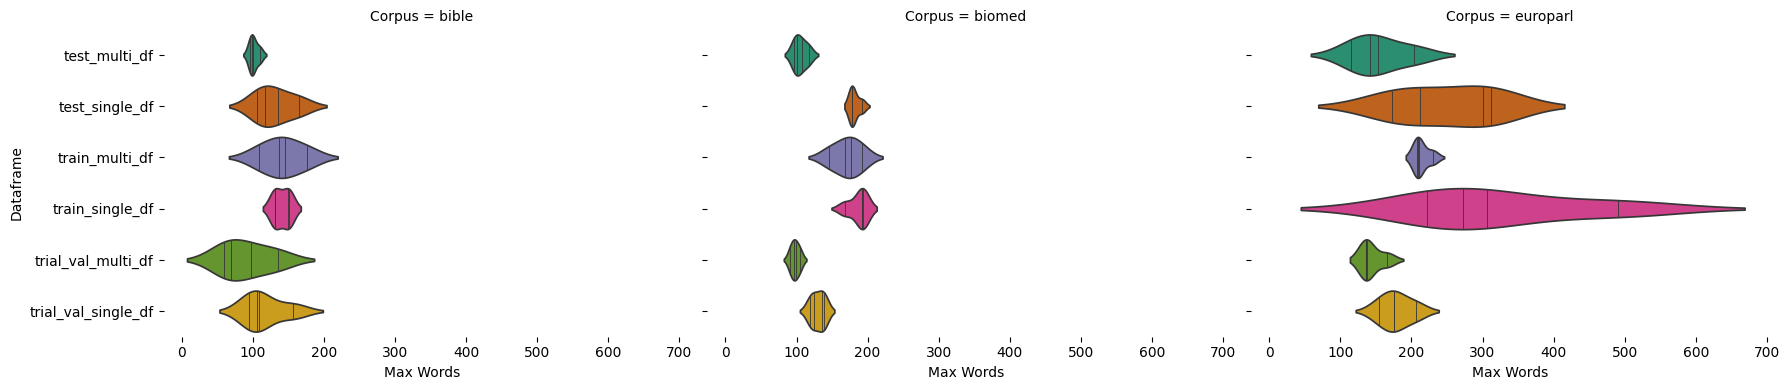

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_pos_seq'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

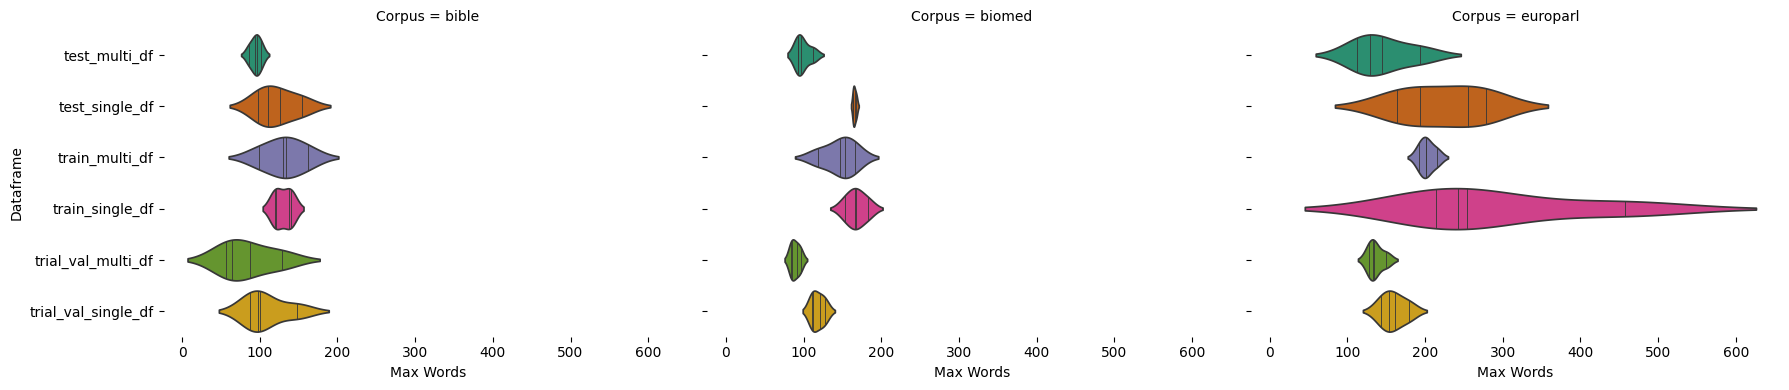

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_pos_alt'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

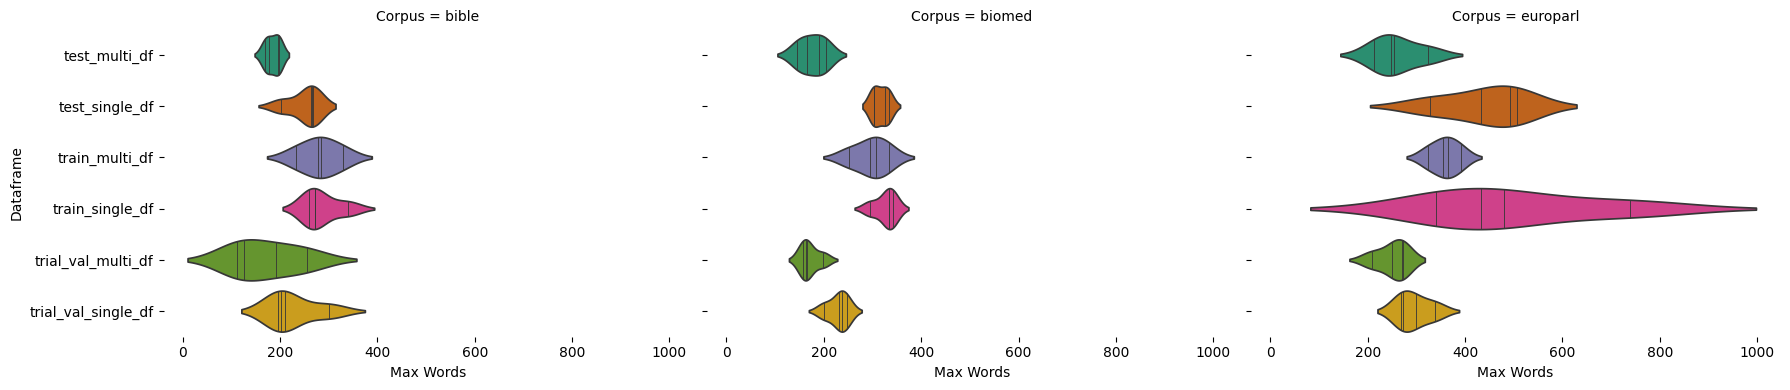

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_morph_seq'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

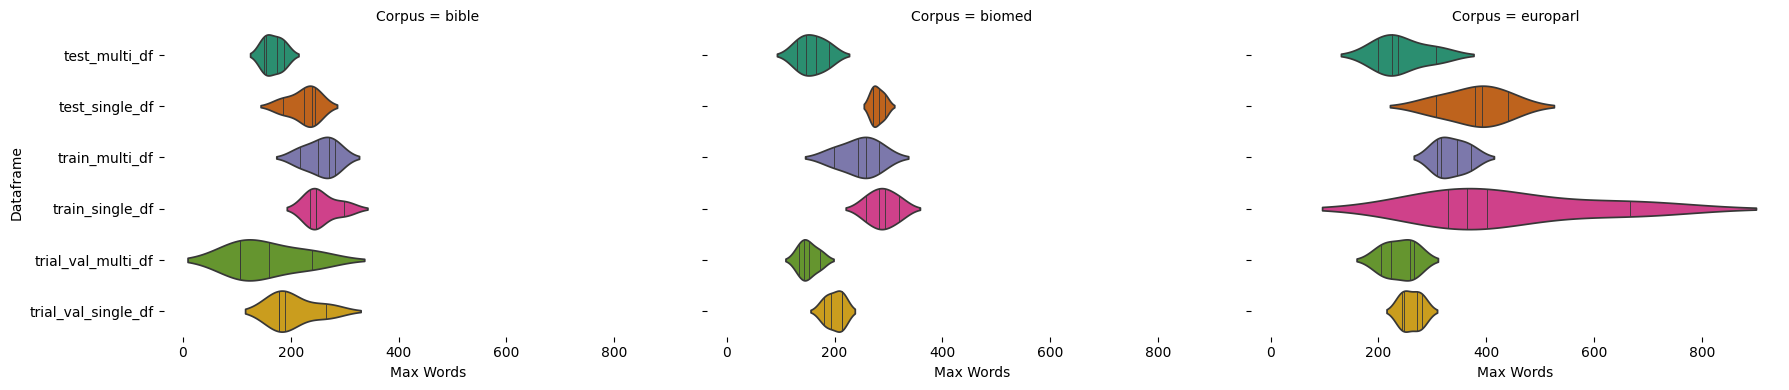

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_morph_alt'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

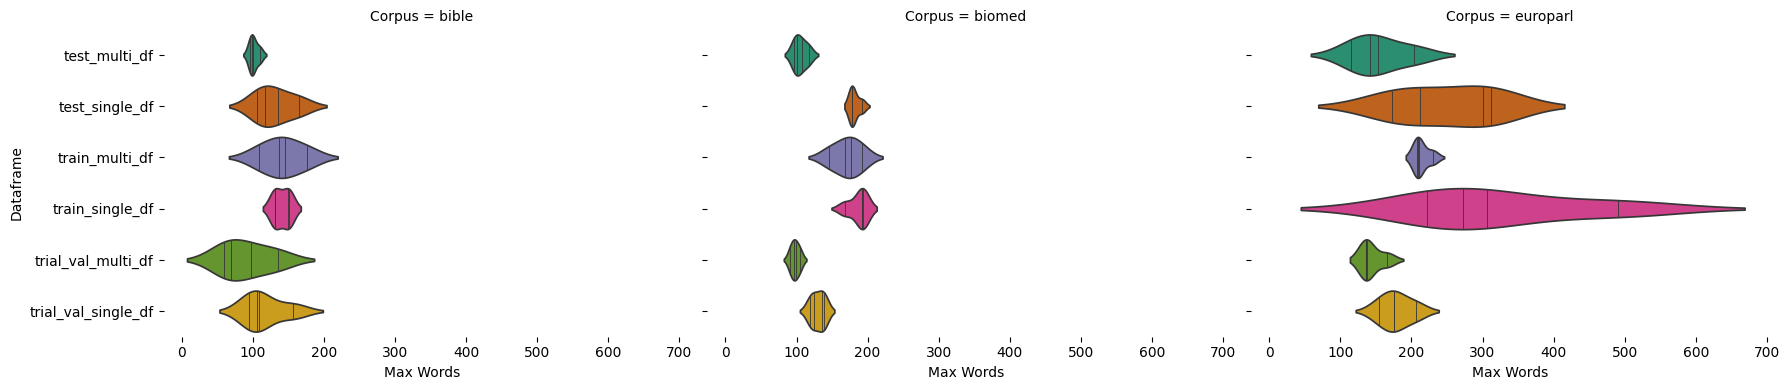

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_dep_seq'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

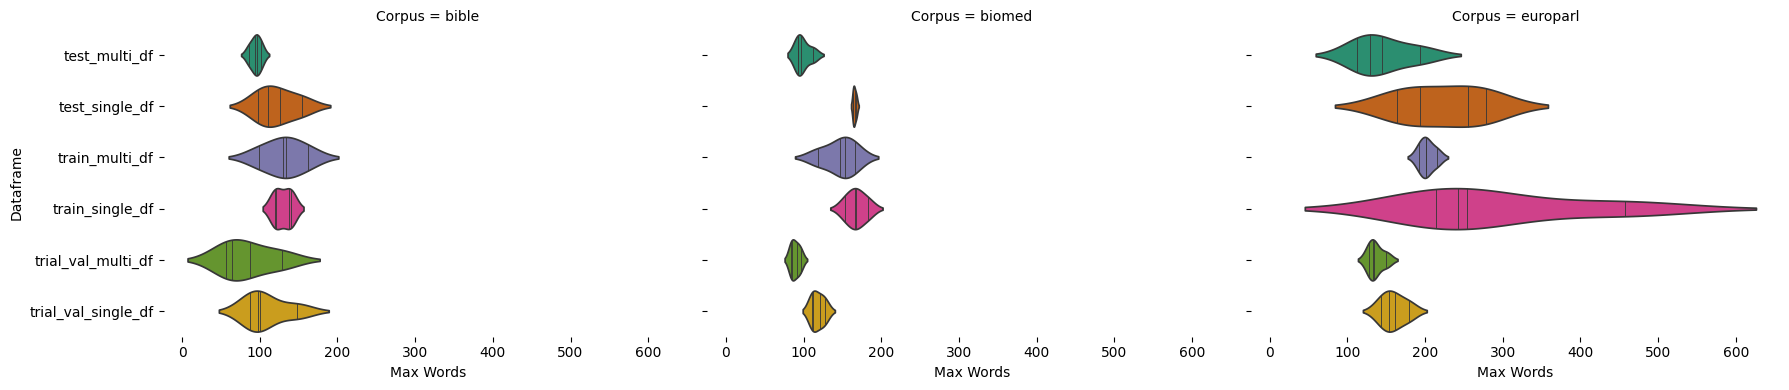

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_dep_alt'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

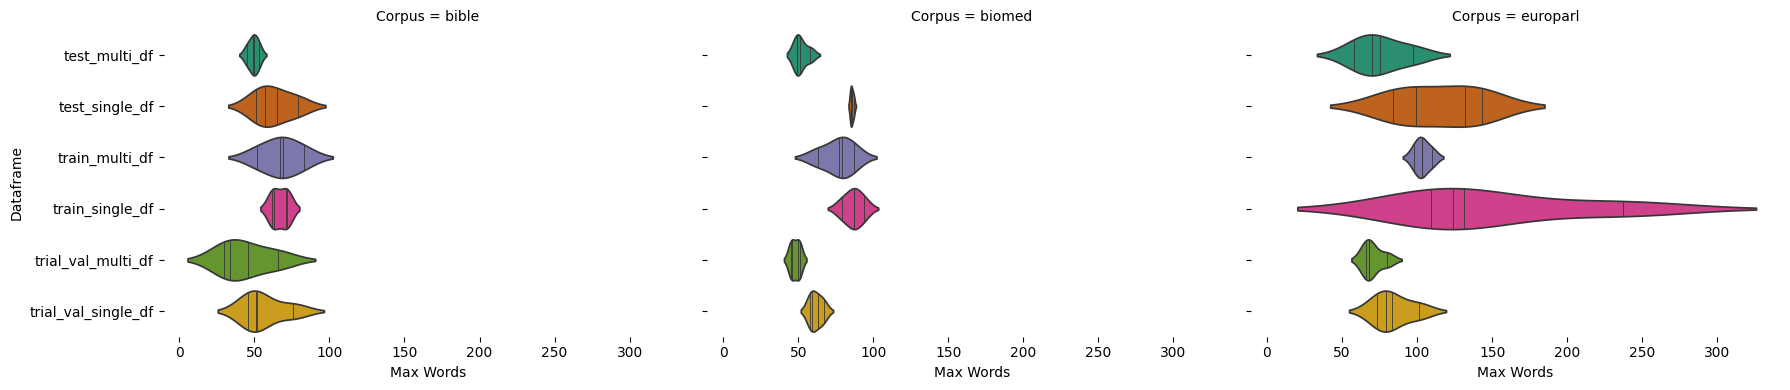

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_morph_complexity_value'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


### Save Dataframes as CSVs

In [ ]:
### Save Dataframes as CSVs

In [ ]:
!tree /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/
├── fe-test-labels
│   ├── test_multi_df.csv
│   └── test_single_df.csv
├── fe-train
│   ├── train_multi_df.csv
│   └── train_single_df.csv
├── fe-trial-val
│   ├── trial_val_multi_df.csv
│   └── trial_val_single_df.csv
├── test-labels
│   ├── lcp_multi_test.tsv
│   └── lcp_single_test.tsv
├── train
│   ├── lcp_multi_train.tsv
│   └── lcp_single_train.tsv
└── trial
    ├── lcp_multi_trial.tsv
    └── lcp_single_trial.tsv

6 directories, 12 files


In [ ]:
import os
dataframes = {
    "train_single_df": train_single_df,
    "train_multi_df": train_multi_df,
    "trial_val_single_df": trial_val_single_df,
    "trial_val_multi_df": trial_val_multi_df,
    "test_single_df": test_single_df,
    "test_multi_df": test_multi_df
}

base_dir = "/content/drive/MyDrive/266-final/data/266-comp-lex-master/"

for df_name, df in dataframes.items():
    subdir = None
    if "train" in df_name:
      subdir = "fe-train"
    elif "trial_val" in df_name:
      subdir = "fe-trial-val"
    elif "test" in df_name:
      subdir = "fe-test-labels"

    if subdir:
      save_path = os.path.join(base_dir, subdir, f"{df_name}.csv")
      os.makedirs(os.path.dirname(save_path), exist_ok=True)
      df.to_csv(save_path, index=False)
      print(f"Saved {df_name} to {save_path}")


Saved train_single_df to /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train/train_single_df.csv
Saved train_multi_df to /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train/train_multi_df.csv
Saved trial_val_single_df to /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val/trial_val_single_df.csv
Saved trial_val_multi_df to /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val/trial_val_multi_df.csv
Saved test_single_df to /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels/test_single_df.csv
Saved test_multi_df to /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels/test_multi_df.csv


In [ ]:
df_names = [
    "train_single_df",
    "train_multi_df",
    "trial_val_single_df",
    "trial_val_multi_df",
    "test_single_df",
    "test_multi_df"
]

loaded_dataframes = {}

for df_name in df_names:
    if "train" in df_name:
        subdir = "fe-train"
    elif "trial_val" in df_name:
        subdir = "fe-trial-val"
    elif "test" in df_name:
        subdir = "fe-test-labels"
    else:
        subdir = None

    if subdir:
        read_path = os.path.join(dir_data, subdir, f"{df_name}.csv")
        loaded_df = pd.read_csv(read_path)
        loaded_dataframes[df_name] = loaded_df
        print(f"Loaded {df_name} from {read_path}")

for df_name, df in loaded_dataframes.items():
    print(f"\n>>> {df_name} shape: {df.shape}")
    if 'binary_complexity' in df.columns:
        print(df['binary_complexity'].value_counts())


Loaded train_single_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train/train_single_df.csv
Loaded train_multi_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train/train_multi_df.csv
Loaded trial_val_single_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val/trial_val_single_df.csv
Loaded trial_val_multi_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val/trial_val_multi_df.csv
Loaded test_single_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels/test_single_df.csv
Loaded test_multi_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels/test_multi_df.csv

>>> train_single_df shape: (7662, 20)
binary_complexity
0    3865
1    3797
Name: count, dtype: int64

>>> train_multi_df shape: (1517, 20)
binary_complexity
0    759
1    758
Name: count, dtype: int64

>>> trial_val_single_df shape: (421, 20)
binary_complexity
0    229
1    192
Nam

In [ ]:
!tree /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/
├── fe-test-labels
│   ├── test_multi_df.csv
│   └── test_single_df.csv
├── fe-train
│   ├── train_multi_df.csv
│   └── train_single_df.csv
├── fe-trial-val
│   ├── trial_val_multi_df.csv
│   └── trial_val_single_df.csv
├── test-labels
│   ├── lcp_multi_test.tsv
│   └── lcp_single_test.tsv
├── train
│   ├── lcp_multi_train.tsv
│   └── lcp_single_train.tsv
└── trial
    ├── lcp_multi_trial.tsv
    └── lcp_single_trial.tsv

6 directories, 12 files


- These counts match my offline calculations exactly.The binarized outcome variables have been split on on the median of the TRAIN_SINGLE and TRAIN_MULTI dataset splits ONLY, thus this median is applied to trial_val and test. The first two quartiles (up to the train median) are equal to 0 in 'binary_complexity' and the next two quartiles are equal to 1.
- Because the dataset has been excellently balanced by the Task's annotators, we're lucky that no further data processing is necessary prior to moving onto the modeling step, and ensuring protection from data leakage by (later) removing necessary columns prior to vectorization.
- Lastly, a note on the balanced nature of the data. It should be noted that (even in the continuous outome representation of 'complexity') the medians were 0.28 in train_single, and 0.27 in both trial_single and test_single—for multi, it was 0.41 in train_multi, and 0.42 in trial_multi and 0.43 in test_multi.
- We also find that after Data Engineering, our sanity checks have come out successfully. No records have been lost, shapes are consistent with our expectations, and we have enriched the dataset with SpaCy-derived features to give us flexibility in multi-channel inputs or vectorization ablations. This is a very thorough dataset, and we are now ready for modeling.